In [1]:
#Run this cell to load dependencies
drive_path = 'e:/'
import numpy as np
import pandas as pd
import os
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

import allensdk.brain_observatory.stimulus_info as stim_info

In [2]:
# locally sparse noise
file_path = r'E:\BrainObservatory\ophys_analysis\*_C_analysis.h5'
file_list = glob.glob(file_path)
mean_sweep_response_l4 = []
mean_sweep_response_l23 = []
mean_sweep_response_l5 = []

for f in file_list:
    tmp = pd.HDFStore(f, "r")
    peak_table = pd.DataFrame(tmp.select('/analysis/peak'))
    mean_sweep_response = pd.DataFrame(tmp.select('/analysis/mean_sweep_response_lsn'))
    
    if peak_table['targeted_structure'][0] == 'VISp':
        if peak_table['imaging_depth'][0] == 175:
            mean_sweep_response_l23.append( mean_sweep_response)
        elif peak_table['imaging_depth'][0] == 375:
            mean_sweep_response_l5.append( mean_sweep_response)
        else:
            mean_sweep_response_l4.append( mean_sweep_response)

In [3]:
data_lsn = boc.get_ophys_experiments(stimuli = ['locally_sparse_noise'])
data_lsn = boc.get_ophys_experiment_data(ophys_experiment_id = data_lsn[0]['id'])
stim_table = data_lsn.get_stimulus_table('locally_sparse_noise')


Exception RuntimeError: RuntimeError('Failed to retrieve old handler',) in 'h5py._errors.set_error_handler' ignored
Exception RuntimeError: RuntimeError('Failed to retrieve old handler',) in 'h5py._errors.set_error_handler' ignored


In [8]:
LSN_ON = 255
LSN_OFF = 0
LSN, LSN_mask = data_lsn.get_locally_sparse_noise_stimulus_template(mask_off_screen=False)

In [11]:
def centroid_population(field, percentile, radius = 4):
    threshold = np.percentile(field[:], percentile)
    xs, ys = np.where(field > threshold)
    centroid = [np.mean(xs), np.mean(ys)]
    num = 0
    for j in range(len(xs)):
        d = np.linalg.norm(centroid - np.array(xs[j], ys[j]))
        if d < radius:
            num += 1
    return num, 1.0*num/len(xs)

def analysis_layer( mean_sweep_response_set, plot=False ):
    size_set = []
    for mean_sweep_response in mean_sweep_response_set:
        num_neuron = mean_sweep_response.shape[1]-1
        receptive_field = np.empty(
            (16, 28, num_neuron + 1, 2))

        for xp in range(16):
            for yp in range(28):
                on_frame = np.where(LSN[:, xp, yp] == LSN_ON)[0]
                off_frame = np.where(LSN[:, xp, yp] == LSN_OFF)[0]
                subset_on = mean_sweep_response[stim_table.frame.isin(on_frame)]
                subset_off = mean_sweep_response[stim_table.frame.isin(off_frame)]
                receptive_field[xp, yp, :, 0] = subset_on.mean(axis=0)
                receptive_field[xp, yp, :, 1] = subset_off.mean(axis=0)

        for neuron in range(num_neuron):
            on_field = receptive_field[:,:,neuron, 0]
            off_field = receptive_field[:,:,neuron, 1]

            percentile = 95

            on_threshold = np.mean(on_field[:]) + 3* np.var(on_field[:])
            off_threshold = np.mean(off_field[:]) + 3 *np.var(off_field[:])

            # filter the neurons by two criterions
            #    1: has a bright spot: np.percentile(on_field[:], percentile) < on_threshold
            #    2: mass distributed around centroid, count population within radius of the centroid

            if (np.percentile(on_field[:], percentile)<on_threshold or np.percentile(off_field[:], percentile)<off_threshold):
                size_on, prop_on = centroid_population(on_field[:], percentile)
                size_off, prop_off = centroid_population(off_field[:], percentile)
                if (prop_on > 0.5 or prop_off > 0.5):
                    if plot == True:
                        plt.figure(figsize=(5,3))
                        plt.subplot(121)
                        plt.imshow(on_field, interpolation='nearest', cmap='PuRd', origin='lower')
                        plt.axis('off')
                        plt.subplot(122)
                        plt.imshow(off_field, interpolation='nearest', cmap='PuRd', origin='lower')
                        plt.axis('off')
                    size_set.append(max(size_on, size_off))
    return size_set

C:\Anaconda2\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


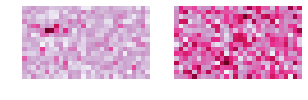

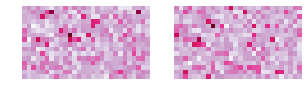

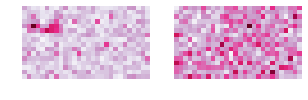

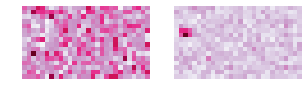

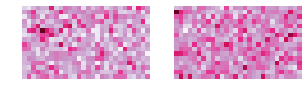

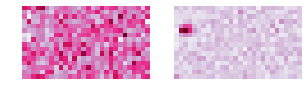

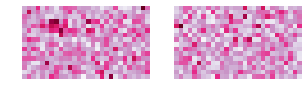

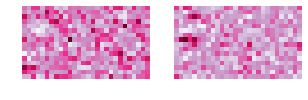

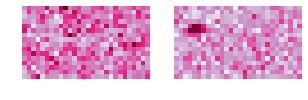

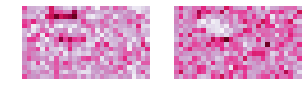

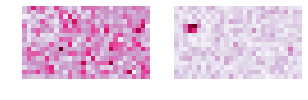

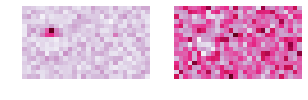

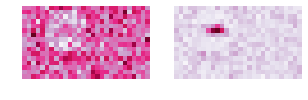

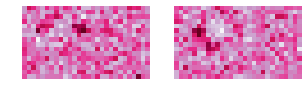

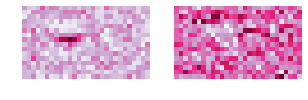

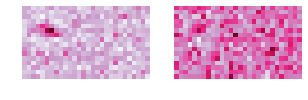

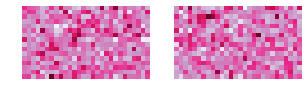

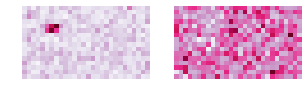

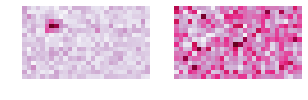

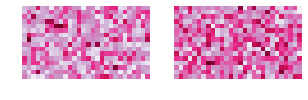

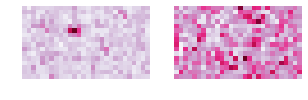

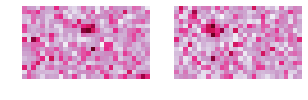

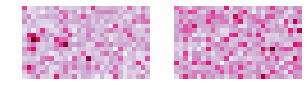

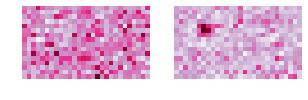

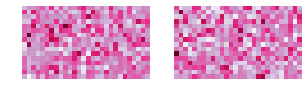

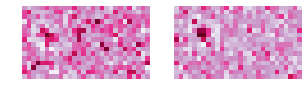

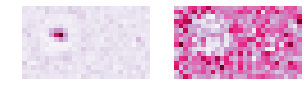

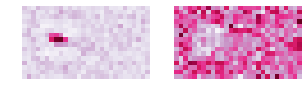

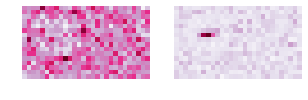

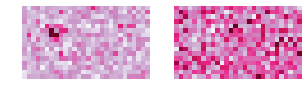

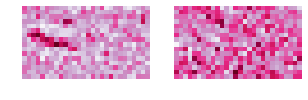

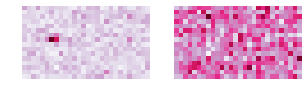

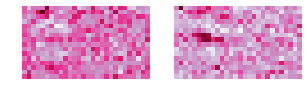

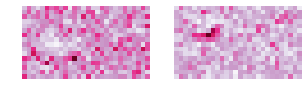

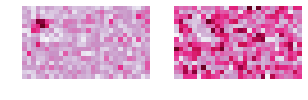

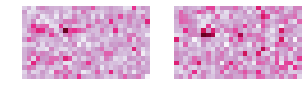

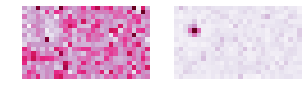

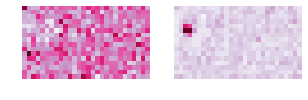

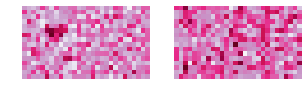

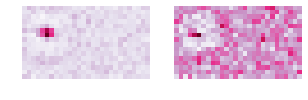

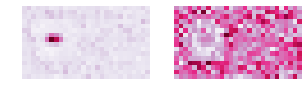

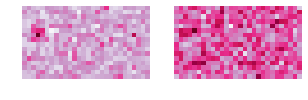

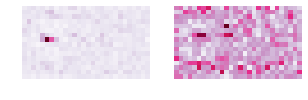

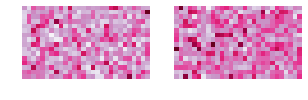

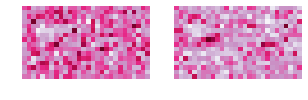

In [12]:
size_set_l5 = analysis_layer(mean_sweep_response_l5, plot=True)

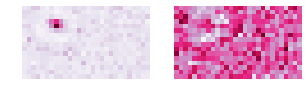

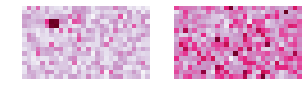

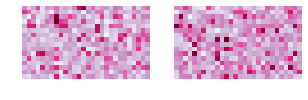

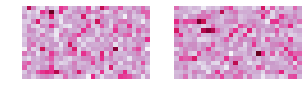

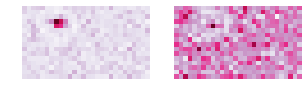

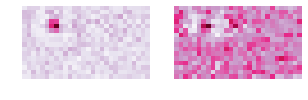

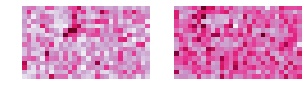

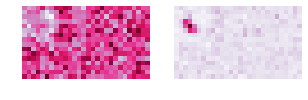

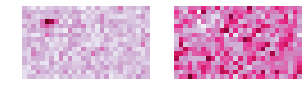

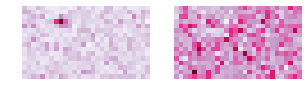

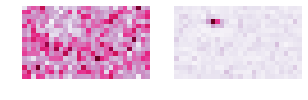

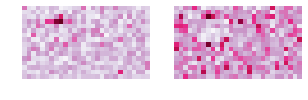

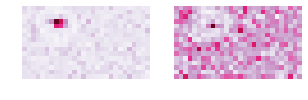

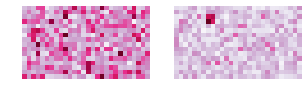

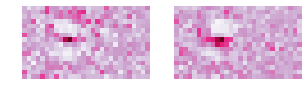

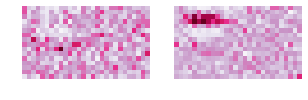

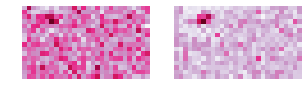

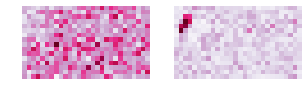

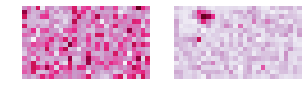

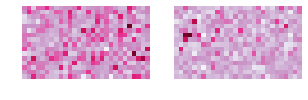

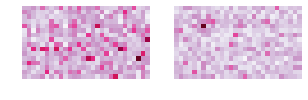

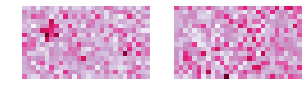

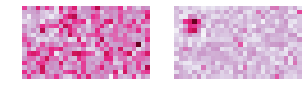

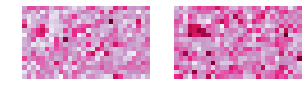

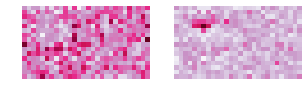

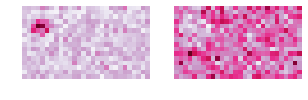

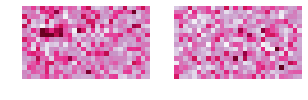

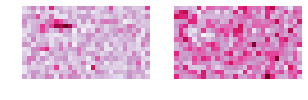

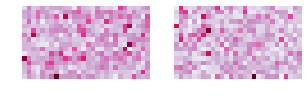

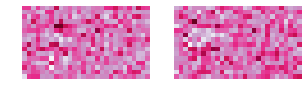

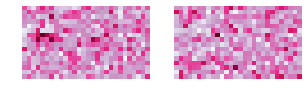

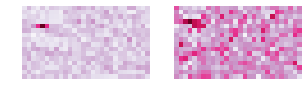

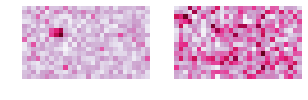

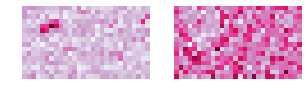

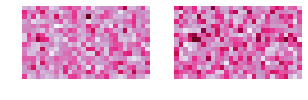

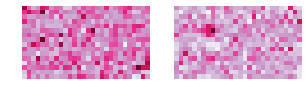

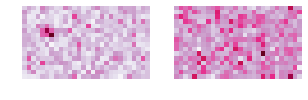

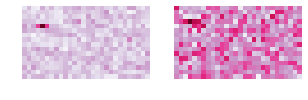

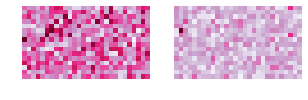

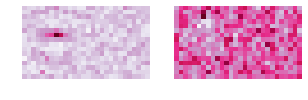

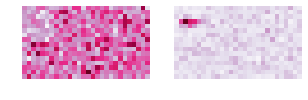

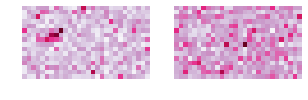

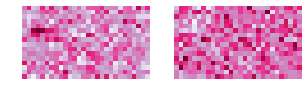

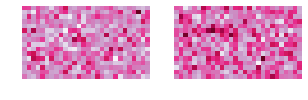

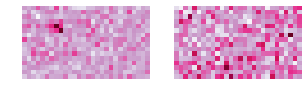

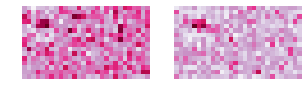

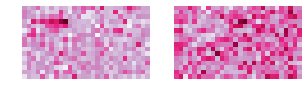

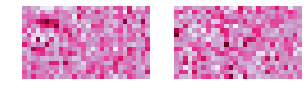

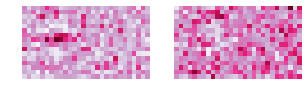

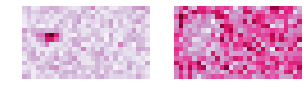

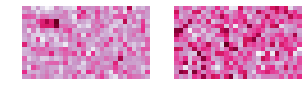

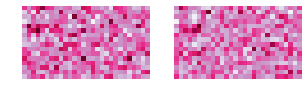

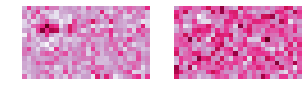

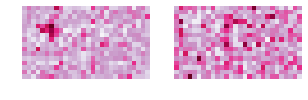

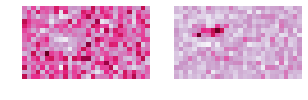

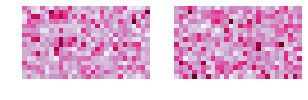

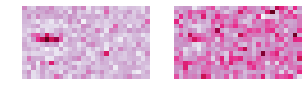

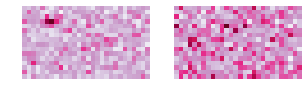

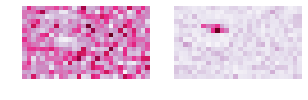

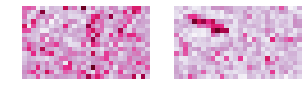

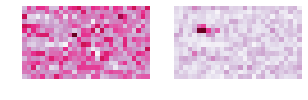

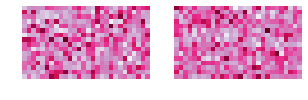

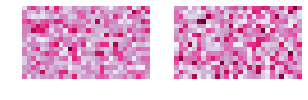

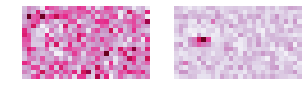

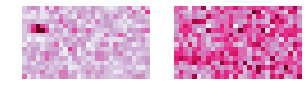

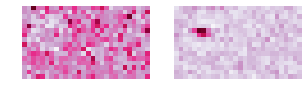

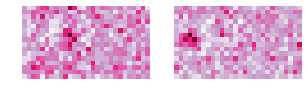

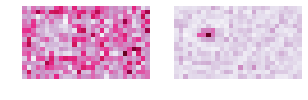

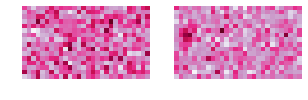

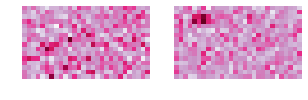

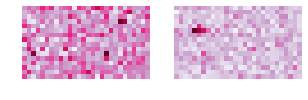

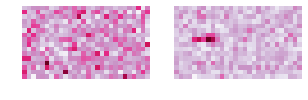

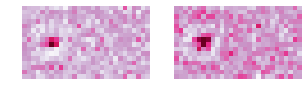

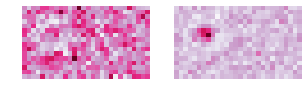

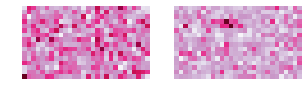

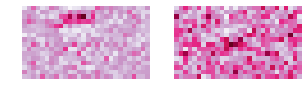

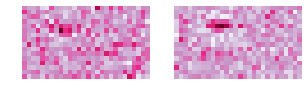

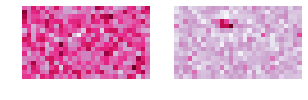

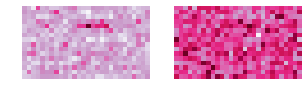

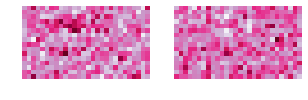

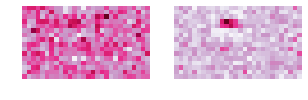

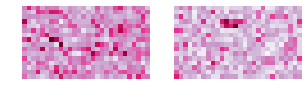

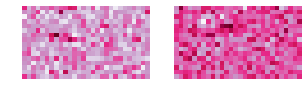

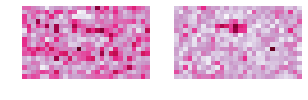

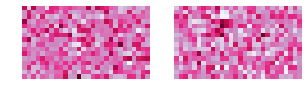

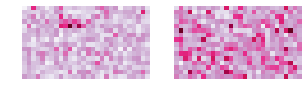

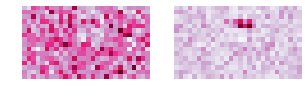

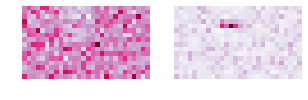

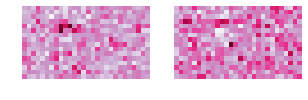

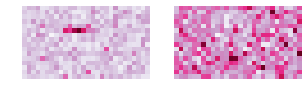

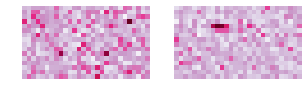

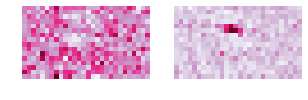

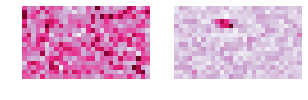

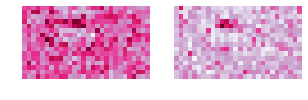

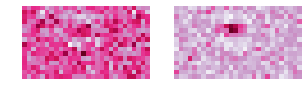

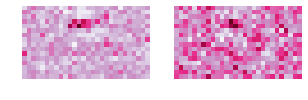

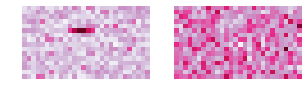

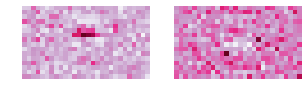

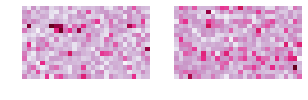

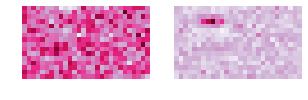

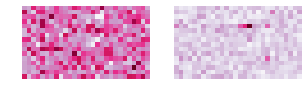

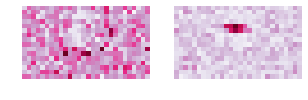

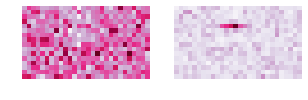

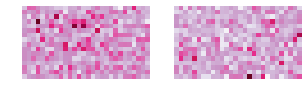

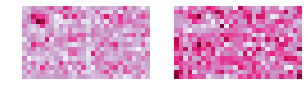

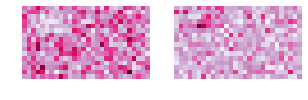

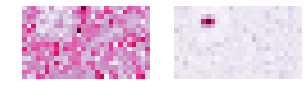

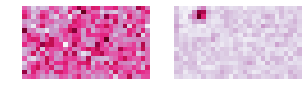

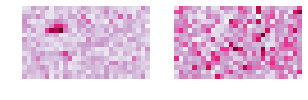

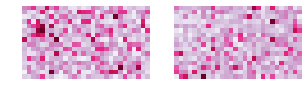

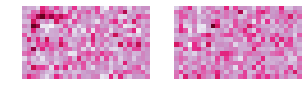

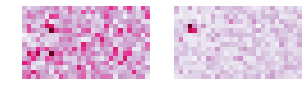

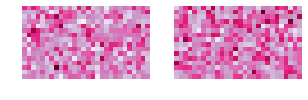

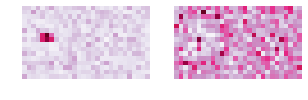

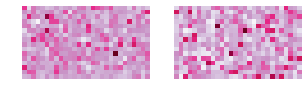

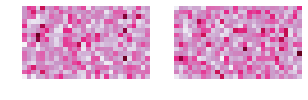

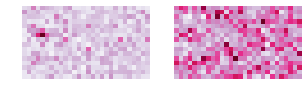

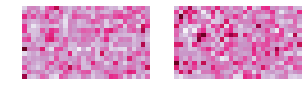

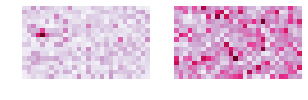

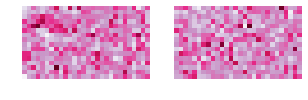

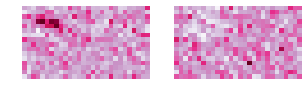

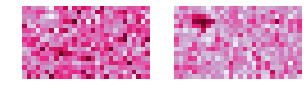

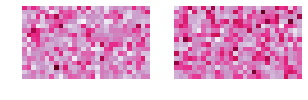

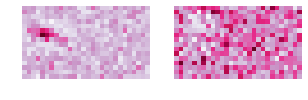

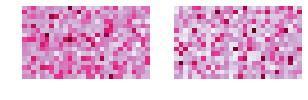

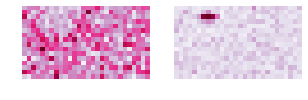

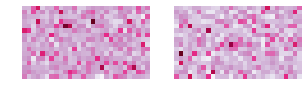

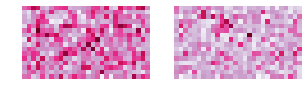

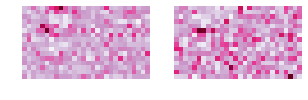

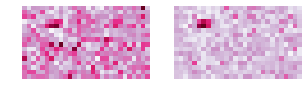

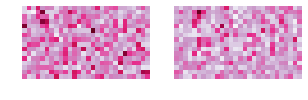

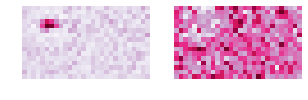

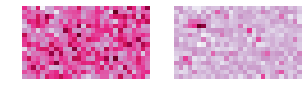

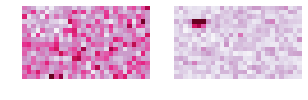

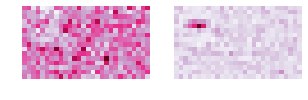

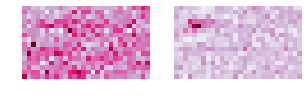

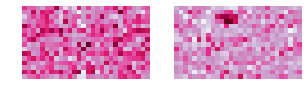

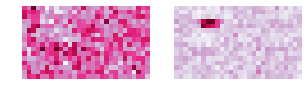

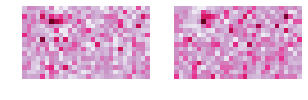

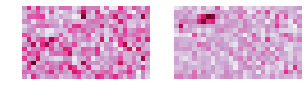

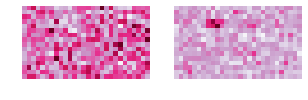

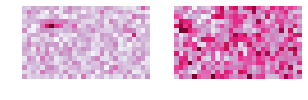

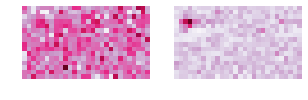

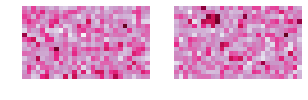

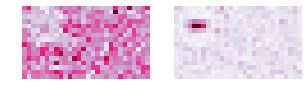

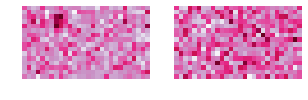

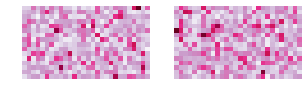

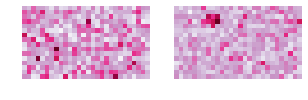

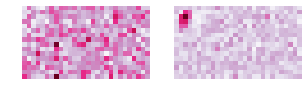

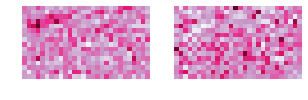

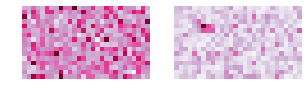

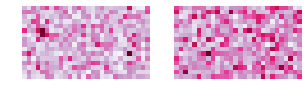

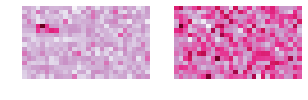

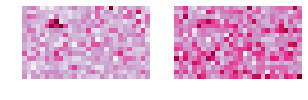

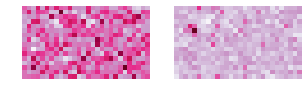

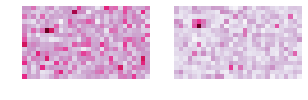

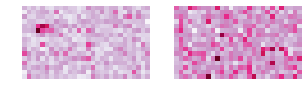

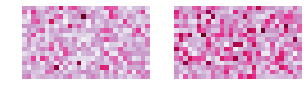

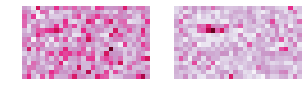

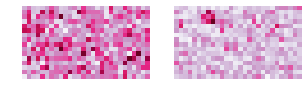

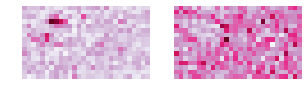

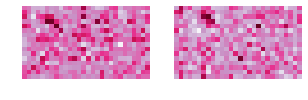

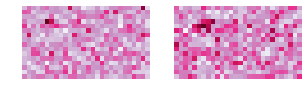

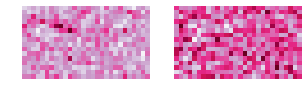

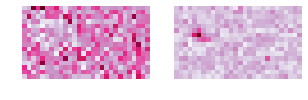

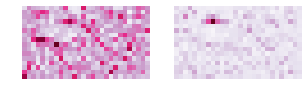

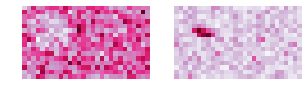

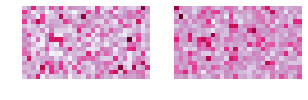

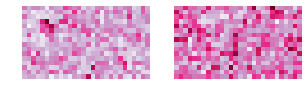

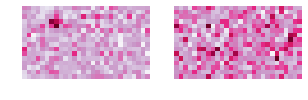

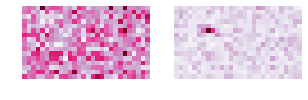

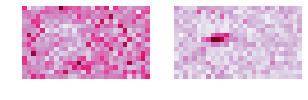

In [13]:
size_set_l4 = analysis_layer(mean_sweep_response_l4, plot=True)

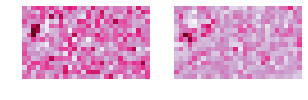

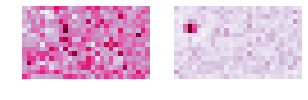

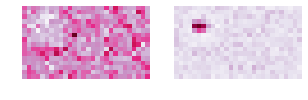

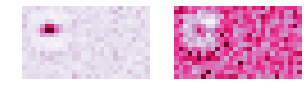

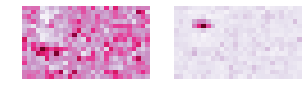

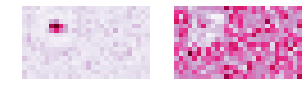

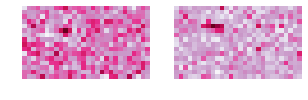

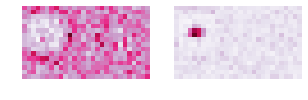

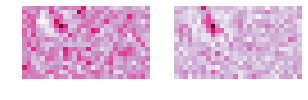

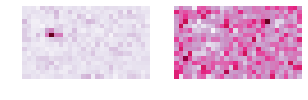

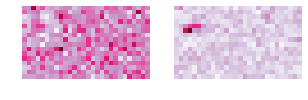

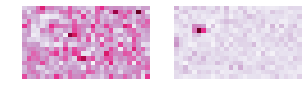

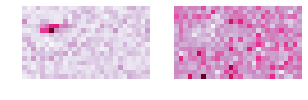

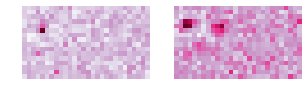

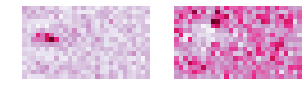

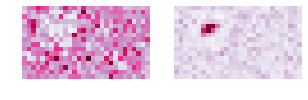

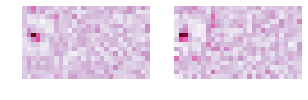

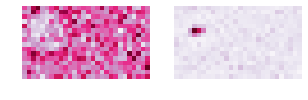

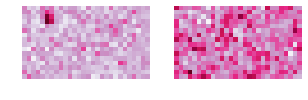

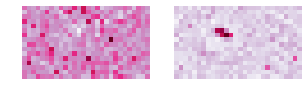

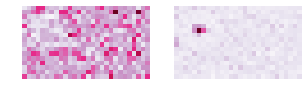

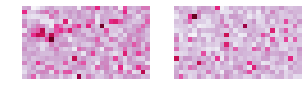

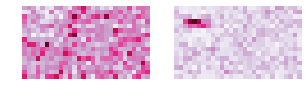

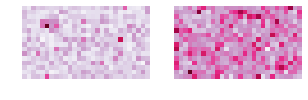

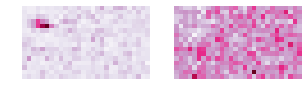

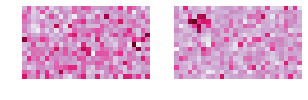

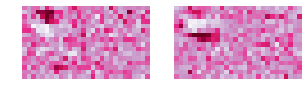

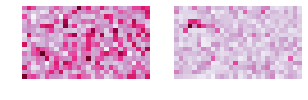

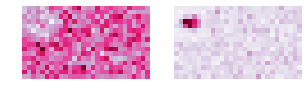

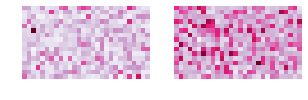

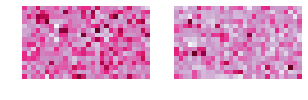

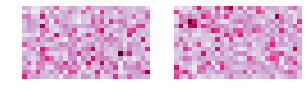

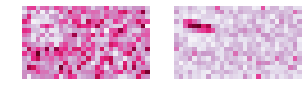

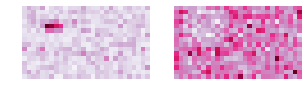

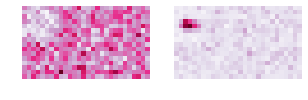

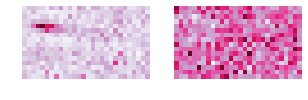

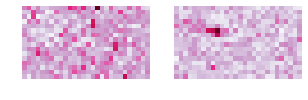

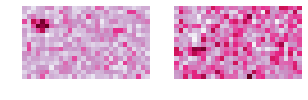

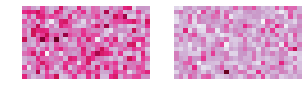

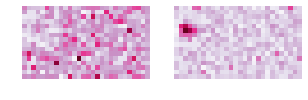

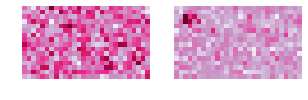

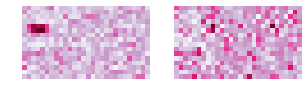

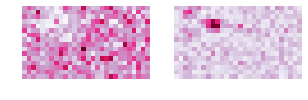

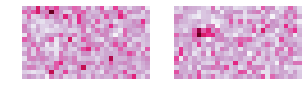

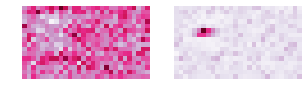

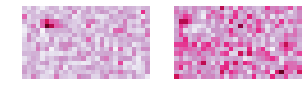

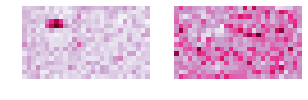

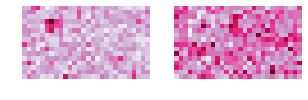

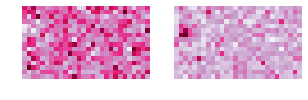

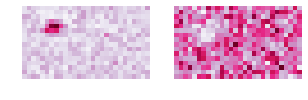

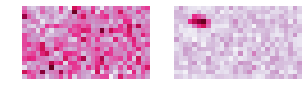

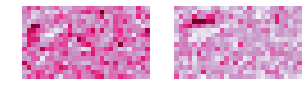

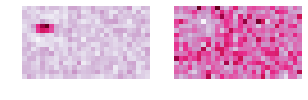

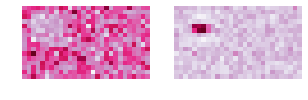

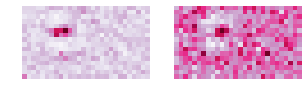

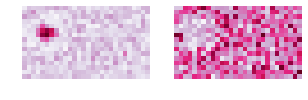

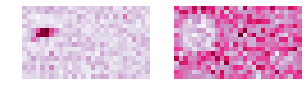

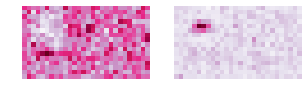

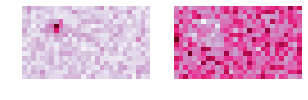

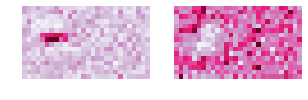

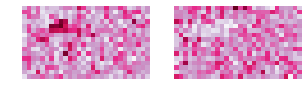

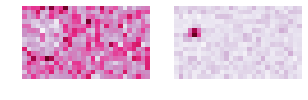

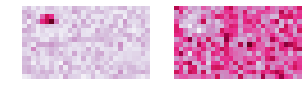

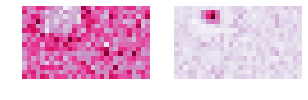

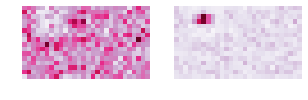

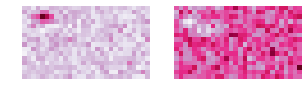

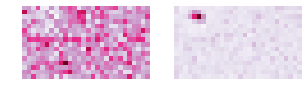

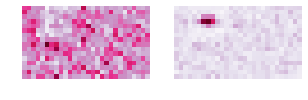

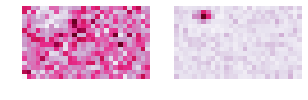

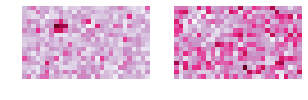

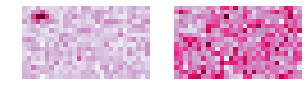

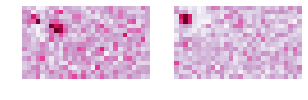

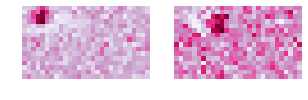

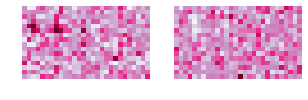

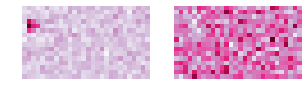

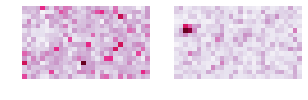

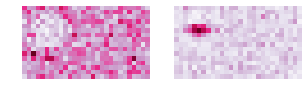

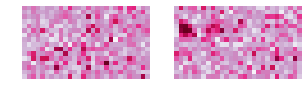

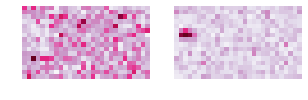

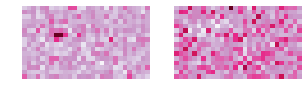

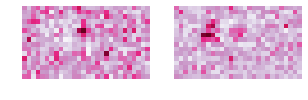

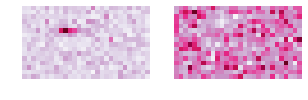

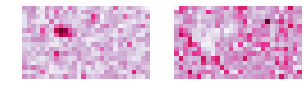

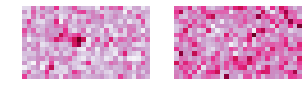

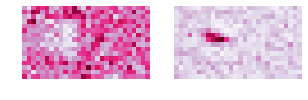

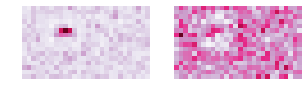

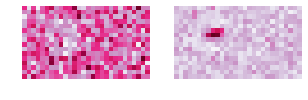

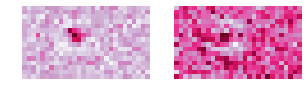

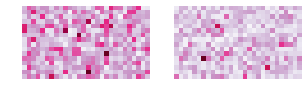

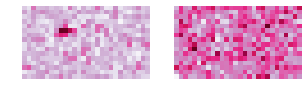

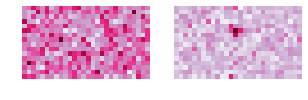

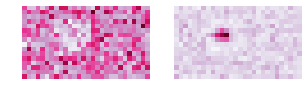

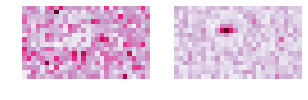

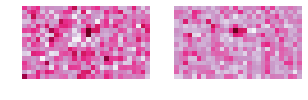

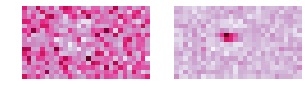

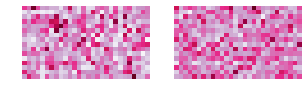

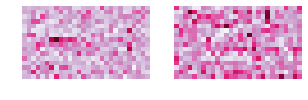

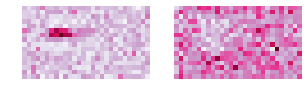

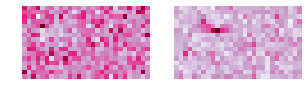

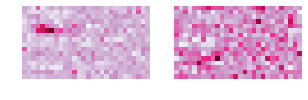

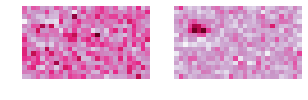

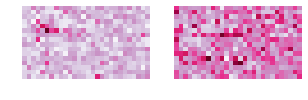

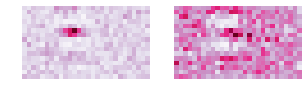

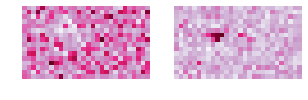

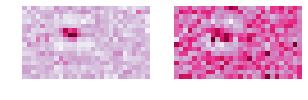

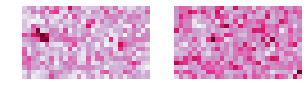

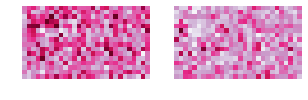

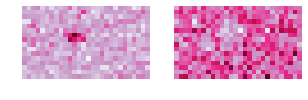

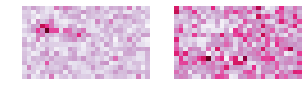

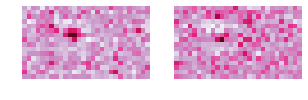

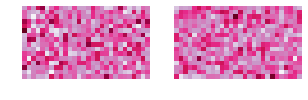

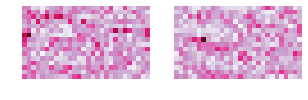

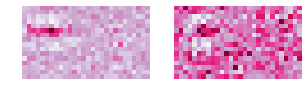

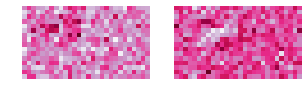

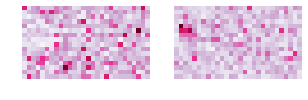

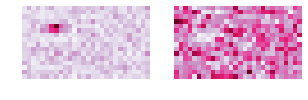

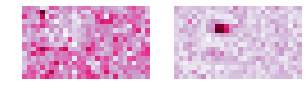

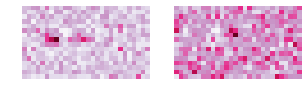

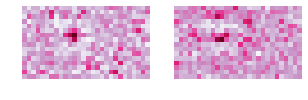

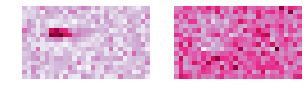

In [14]:
size_set_l23 = analysis_layer(mean_sweep_response_l23, plot=True)

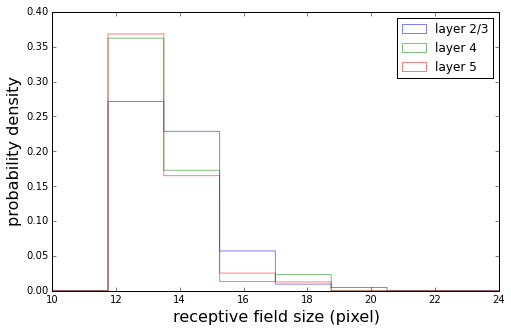

In [36]:
bins = 8
plt.figure(figsize=(8,5))
plt.hist(size_set_l23, histtype='step', bins=bins, normed=True, range=[10,24], alpha = 0.5, label = 'layer 2/3')
plt.hist(size_set_l4, histtype='step', bins=bins,normed=True,range=[10,24], alpha = 0.5, label = 'layer 4')
plt.hist(size_set_l5, histtype='step', bins=bins,normed=True, range=[10,24], alpha = 0.5, label = 'layer 5')
plt.ylim([0,0.4])
plt.ylabel('probability density', fontsize = 16)
plt.xlabel('receptive field size (pixel)', fontsize = 16)
plt.legend()